In [1]:
from newsapi import NewsApiClient
from datetime import datetime
import spacy
import nltk
from nltk.corpus import stopwords
from string import punctuation
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim import corpora
from gensim.models import LdaModel
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from datetime import datetime, timedelta
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from transformers import pipeline
from transformers import AutoTokenizer

# Download NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stop_words = set(stopwords.words('english'))

# Load spaCy English model
try:
    nlp = spacy.load('en_core_web_sm')
    print("spaCy model loaded successfully!")
    print(f"spaCy version: {spacy.__version__}")
except Exception as e:
    print(f"Failed to load spaCy model: {e}")
    raise

# Initialize NewsAPI client
api_key = "ecd7570da7af41e3b04a08781e1cabaf"
newsapi = NewsApiClient(api_key=api_key)

# Initialize VADER sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Initialize Sumy summarizer
summarizer = LsaSummarizer()

# Initialize BERT tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
except Exception as e:
    print(f"Failed to load BERT tokenizer: {e}. Falling back to character-based truncation.")
    tokenizer = None

# Initialize sentiment pipeline
try:
    sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')
except Exception as e:
    print(f"Failed to load sentiment pipeline: {e}. Will fall back to VADER.")
    sentiment_pipeline = None

/home/agrima/anaconda3/envs/my_new_env/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/agrima/anaconda3/envs/my_new_env/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please s

spaCy model loaded successfully!
spaCy version: 3.7.0


In [2]:
def get_news_for_date(date: str) -> list:
    """
    Fetch at least 15 news articles for a single date using NewsAPI, targeting informative topics.
    """
    try:
        datetime.strptime(date, '%Y-%m-%d')  # Validate date format
    except ValueError:
        print("Incorrect date format, please use 'YYYY-MM-DD'.")
        return []

    query = '("global politics" OR "economy" OR "climate change" OR "conflict" OR "technology innovation" OR "public health" OR "diplomacy" OR "crisis" OR "trade war" OR "policy") -entertainment -celebrity'
    sources = 'bbc-news,reuters,the-guardian,the-new-york-times,associated-press,cnn,france-24-english,deutsche-welle'
    min_articles = 15

    try:
        response = newsapi.get_everything(
            q=query,
            from_param=date,
            to=date,
            language='en',
            sources=sources,
            sort_by='relevancy',
            page_size=100
        )
        if response['status'] == 'ok':
            articles = response['articles']
            print(f"Fetched {len(articles)} articles for {date}")
            # Fallback query if too few articles
            if len(articles) < min_articles:
                print("Too few articles, trying broader query...")
                response = newsapi.get_everything(
                    q='("global politics" OR "economy" OR "climate change" OR "conflict" OR "public health" OR "sports" OR "diplomacy" OR "crisis" OR "health") -entertainment -celebrity',
                    from_param=date,
                    to=date,
                    language='en',
                    sources=sources,
                    sort_by='relevancy',
                    page_size=100
                )
                if response['status'] == 'ok':
                    articles = response['articles']
                    print(f"Fetched {len(articles)} articles with fallback query")
            return articles
        else:
            print(f"Error: {response.get('message', 'Failed to fetch news')}")
            return []
    except Exception as e:
        print(f"Request failed: {e}")
        return []

In [3]:
import re
import time
import requests
import os
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

# Suppress Hugging Face tokenizers parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def clean_html(html: str) -> str:
    """Clean raw HTML by removing scripts, styles, comments, and boilerplate."""
    html = re.sub(r'<!--[\s\S]*?-->', '', html)
    html = re.sub(r'<script[\s\S]*?</script>', '', html)
    html = re.sub(r'<style[\s\S]*?</style>', '', html)
    html = re.sub(r'<(nav|footer|aside|header|form|iframe|video)[\s\S]*?</\1>', '', html, flags=re.IGNORECASE)
    html = re.sub(r'\s+', ' ', html)
    return html.strip()

def clean_text(text: str, max_tokens: int = 510) -> str:
    """Clean and truncate text to fit BERT's 512-token limit (510 + [CLS] + [SEP])."""
    text = re.sub(r'\n\s*\n', '\n', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'(Share this article|Follow us on|Subscribe to|Read more|Updated \d+:\d+|CNN\s*\|\s*Video|Watch now)', '', text, flags=re.IGNORECASE)
    text = text.strip()

    if tokenizer:
        # Token-based truncation
        tokens = tokenizer.encode(text, add_special_tokens=False)
        if len(tokens) > max_tokens:
            tokens = tokens[:max_tokens]
            text = tokenizer.decode(tokens, skip_special_tokens=True)
    else:
        # Fallback to character-based truncation
        max_chars = max_tokens * 4
        if len(text) > max_chars:
            text = text[:max_chars].rsplit(' ', 1)[0] + '...'

    return text
# ... (keep imports, clean_html, clean_text as is)
def scrape_full_text(url: str, timeout: int = 15, retries: int = 2, max_tokens: int = 510) -> str:
    """
    Scrape article text, skipping video pages and limiting to 510 tokens for BERT.
    Uses requests with Selenium fallback for dynamic content.
    """
    if not url or not url.startswith('http'):
        print(f"Invalid URL: {url}")
        return ''

    # Skip live updates and video pages
    if any(keyword in url.lower() for keyword in ['live-news', 'live-updates', '/video/']):
        print(f"Skipping non-article page (live updates or video): {url}")
        return ''

    # Try requests (preferred for static content)
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36'
    }
    for attempt in range(retries + 1):
        try:
            response = requests.get(url, headers=headers, timeout=timeout)
            response.raise_for_status()
            soup = BeautifulSoup(clean_html(response.text), 'lxml')

            # Remove unwanted elements, including video-related
            for element in soup(['nav', 'footer', 'aside', 'header', 'script', 'style', 'form', 'iframe', 
                               'div[class*="comment"]', 'div[class*="share"]', 'div[class*="video"]', 'video']):
                element.decompose()

            # Target article content
            content_elements = []
            article_tag = soup.find('article')
            if article_tag:
                content_elements.extend(article_tag.find_all('p', recursive=True))

            # CNN/BBC-specific article body classes
            content_elements.extend(soup.find_all('p', class_=[
                'article-body', 'story-body', 'post-content', 'article-content', 'body-content',
                'entry-content', 'content-inner', 'zn-body__paragraph', 'ssrcss-1q0x1qg-Paragraph'
            ]))

            # Fallback to main content area
            if not content_elements:
                main_content = soup.find(['main', 'div'], class_=[
                    'content', 'main-content', 'article', 'story', 'post', 'zn-body', 'ssrcss-uf6wea-RichTextContainer'
                ])
                if main_content:
                    content_elements = main_content.find_all('p')

            # Filter out irrelevant paragraphs
            filtered_elements = [
                el for el in content_elements
                if el.get_text(strip=True)
                and len(el.get_text(strip=True)) > 30
                and not el.find_parents(['figcaption', 'cite', 'blockquote', 'div[class*="meta"]', 'div[class*="video"]', 'video'])
                and not any(keyword in el.get_text().lower() for keyword in ['advertisement', 'newsletter', 'subscribe', 'video', 'watch'])
            ]

            # Truncate each paragraph and join
            scraped_text = ' '.join(clean_text(el.get_text(strip=True), max_tokens=max_tokens // len(filtered_elements or 1)) for el in filtered_elements)
            if len(scraped_text) > 150:
                print(f"Scraped {len(scraped_text)} characters from {url} (requests)")
                print(f"Sample: {scraped_text[:200]}")
                # Final truncation to ensure <= 510 tokens
                return clean_text(scraped_text, max_tokens=max_tokens)
            print(f"Insufficient content ({len(scraped_text)} chars) from {url}, trying Selenium...")
            break
        except requests.exceptions.RequestException as e:
            if attempt == retries:
                print(f"Requests failed for {url} after {retries + 1} attempts: {e}")
            else:
                print(f"Retrying {url} (attempt {attempt + 2}/{retries + 1})...")
                time.sleep(1)

    # Fallback to Selenium for dynamic content
    try:
        chrome_options = Options()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--disable-gpu')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chrome_options.add_argument('--user-agent=' + headers['User-Agent'])
        driver = None
        for attempt in range(retries + 1):
            try:
                driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
                driver.set_page_load_timeout(timeout + 5)
                driver.get(url)
                time.sleep(3)

                selectors = (
                    'article p, '
                    '.article-body p, .story-body p, .post-content p, '
                    '.article-content p, .body-content p, .entry-content p, '
                    'main p, .content p, .main-content p, .zn-body__paragraph, '
                    '.ssrcss-1q0x1qg-Paragraph'
                )
                content_elements = driver.find_elements(By.CSS_SELECTOR, selectors)

                scraped_text = ' '.join(
                    clean_text(el.text, max_tokens=max_tokens // len(content_elements or 1)) for el in content_elements
                    if el.text.strip() and len(el.text.strip()) > 30
                    and not any(keyword in el.text.lower() for keyword in ['advertisement', 'newsletter', 'subscribe', 'video', 'watch'])
                )

                if len(scraped_text) > 150:
                    print(f"Scraped {len(scraped_text)} characters from {url} (Selenium)")
                    print(f"Sample: {scraped_text[:200]}")
                    # Final truncation
                    return clean_text(scraped_text, max_tokens=max_tokens)
                print(f"Insufficient content ({len(scraped_text)} chars) from {url} (Selenium)")
                return ''
            except Exception as e:
                if attempt == retries:
                    print(f"Selenium failed for {url} after {retries + 1} attempts: {e}")
                    return ''
                print(f"Retrying Selenium for {url} (attempt {attempt + 2}/{retries + 1})...")
                time.sleep(2)
            finally:
                if driver:
                    driver.quit()
    except ImportError:
        print(f"Selenium not installed or failed for {url}. Install packages: 'pip install selenium webdriver-manager'.")
        return ''
    except Exception as e:
        print(f"Selenium setup failed for {url}: {e}")
        return ''

In [4]:
import yake
kw_extractor = yake.KeywordExtractor(n=3, top=5)
def extract_keywords_yake(processed_articles: list, top_k: int = 5) -> list:
    keywords = [[] for _ in processed_articles]
    for idx, article in enumerate(processed_articles):
        if article['original_text'].strip():
            kws = kw_extractor.extract_keywords(article['original_text'])
            keywords[idx] = [(kw, 1 - score) for kw, score in kws[:top_k]]
    return keywords


In [5]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import logging
import pandas as pd

def extract_topics(processed_articles, num_topics=5, text_key='original_text'):
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Extract valid text
    valid_articles = []
    for article in processed_articles:
        text = article.get(text_key, '') if isinstance(article, dict) else article
        if text and isinstance(text, str) and len(text.strip()) > 50:
            valid_articles.append(text.strip())

    logger.info(f"Number of valid articles for LDA: {len(valid_articles)}")

    if len(valid_articles) < num_topics:
        logger.warning(f"Too few valid articles ({len(valid_articles)} < {num_topics}).")
        return [0] * len(processed_articles), pd.DataFrame({
            'Topic': range(num_topics),
            'Words': [f"Topic {i}" for i in range(num_topics)]
        })

    # Tokenize and create dictionary
    tokenized_articles = [article.lower().split() for article in valid_articles]
    dictionary = Dictionary(tokenized_articles)
    dictionary.filter_extremes(no_below=1, no_above=0.7)  # Less aggressive filtering
    corpus = [dictionary.doc2bow(text) for text in tokenized_articles]

    if not corpus:
        logger.warning("Empty corpus after preprocessing.")
        return [0] * len(processed_articles), pd.DataFrame({
            'Topic': range(num_topics),
            'Words': [f"Topic {i}" for i in range(num_topics)]
        })

    # Train LDA model
    try:
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, 
                             passes=15, iterations=100, random_state=42)
    except Exception as e:
        logger.error(f"LDA model training failed: {e}")
        return [0] * len(processed_articles), pd.DataFrame({
            'Topic': range(num_topics),
            'Words': [f"Topic {i}" for i in range(num_topics)]
        })

    # Extract topic labels
    topic_labels = []
    for article in processed_articles:
        text = article.get(text_key, '') if isinstance(article, dict) else article
        if not text or not isinstance(text, str) or len(text.strip()) <= 50:
            topic_labels.append(0)
            continue
        bow = dictionary.doc2bow(text.lower().split())
        topics = lda_model[bow]
        topic_labels.append(max(topics, key=lambda x: x[1])[0] if topics else 0)

    # Generate topic names
    topic_names = []
    for idx, topic in lda_model.print_topics(num_words=5):
        try:
            terms = [term.split('*')[1].strip('"') for term in topic[1].split(' + ')]
            weights = [float(term.split('*')[0]) for term in topic[1].split(' + ')]
            topic_name = ', '.join([f"{word} ({weight:.3f})" for word, weight in zip(terms, weights)])
            topic_names.append(topic_name)
        except Exception as e:
            logger.warning(f"Error processing topic {idx}: {e}")
            topic_names.append(f"Topic {idx}")

    topic_info = pd.DataFrame({
        'Topic': range(len(topic_names)),
        'Words': topic_names
    })

    return topic_labels, topic_info

In [6]:
def preprocess_article(article: dict) -> dict:
    """
    Preprocess an article with spaCy, VADER, Sumy, and dependency parsing.
    """
    title = '' if article.get('title') is None else article.get('title', '')
    description = '' if article.get('description') is None else article.get('description', '')
    content = '' if article.get('content') is None else article.get('content', '')
    full_text = title + ' ' + content + ' ' + scrape_full_text(article.get('url', ''))
    if not full_text.strip():
        return {
            'title': title,
            'description': description,
            'content': content,
            'original_text': '',
            'tokens': [],
            'lemmatized_tokens': [],
            'entities': [],
            'sentiment': {'compound': 0.0, 'pos': 0.0, 'neu': 0.0, 'neg': 0.0},
            'summary': '',
            'relations': []
        }
    doc = nlp(full_text)
    tokens = [
        token.text.lower() for token in doc
        if token.text.lower() not in stop_words and token.text not in punctuation and len(token.text) > 3
    ]
    lemmatized_tokens = [
        token.lemma_ for token in doc
        if token.text.lower() not in stop_words and token.text not in punctuation and len(token.text) > 3
    ]
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Initialize sentiment pipeline once
try:
    sentiment_pipeline = pipeline('sentiment-analysis', 
                                model='distilbert-base-uncased-finetuned-sst-2-english',
                                device=-1)  # Force CPU
    print("Sentiment pipeline loaded successfully!")
except Exception as e:
    print(f"Failed to load sentiment pipeline: {e}. Using VADER.")
    sentiment_pipeline = None

def preprocess_article(article: dict) -> dict:
    title = '' if article.get('title') is None else article.get('title', '')
    description = '' if article.get('description') is None else article.get('description', '')
    content = '' if article.get('content') is None else article.get('content', '')
    full_text = title + ' ' + content + ' ' + scrape_full_text(article.get('url', ''))
    
    if not full_text.strip():
        return {
            'title': title, 'description': description, 'content': content,
            'original_text': '', 'tokens': [], 'lemmatized_tokens': [],
            'entities': [], 'sentiment': {'compound': 0.0, 'pos': 0.0, 'neu': 0.0, 'neg': 0.0},
            'summary': '', 'relations': []
        }

    doc = nlp(full_text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in stop_words and token.text not in punctuation and len(token.text) > 3]
    lemmatized_tokens = [token.lemma_ for token in doc if token.text.lower() not in stop_words and token.text not in punctuation and len(token.text) > 3]
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Sentiment analysis
    if sentiment_pipeline:
        try:
            # Truncate to 510 tokens
            tokens = tokenizer.encode(full_text, add_special_tokens=False, max_length=510, truncation=True)
            print(f"Token count for {article.get('url', 'No URL')}: {len(tokens)}")
            truncated_text = tokenizer.decode(tokens, skip_special_tokens=True)
            sentiment_result = sentiment_pipeline(truncated_text)[0]
            label = sentiment_result['label']
            score = sentiment_result['score']
            if label == 'POSITIVE':
                sentiment = {'compound': score, 'pos': score, 'neu': 1 - score, 'neg': 0.0}
            else:
                sentiment = {'compound': -score, 'pos': 0.0, 'neu': 1 - score, 'neg': score}
        except Exception as e:
            print(f"Sentiment analysis failed for article: {e}. Falling back to VADER.")
            sentiment = sentiment_analyzer.polarity_scores(full_text)
    else:
        sentiment = sentiment_analyzer.polarity_scores(full_text)

    parser = PlaintextParser.from_string(full_text, Tokenizer("english"))
    summary_sentences = summarizer(parser.document, 2)
    summary = ' '.join(str(sentence) for sentence in summary_sentences)
    relations = []
    for sent in doc.sents:
        for token in sent:
            if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
                obj = next((child.text for child in token.head.children if child.dep_ in ('dobj', 'attr', 'pobj')), None)
                if obj:
                    relations.append((token.text, token.head.text, obj))

    return {
        'title': title, 'description': description, 'content': content,
        'original_text': full_text, 'tokens': tokens, 'lemmatized_tokens': lemmatized_tokens,
        'entities': entities, 'sentiment': sentiment, 'summary': summary, 'relations': relations
    }

Sentiment pipeline loaded successfully!


Fetched 29 articles for 2025-04-23
Found 29 articles for 2025-04-23
Processing articles 1 to 5 of 29...
Article 1: Trump says China tariffs will ‘come down substantially,’ hinting at potential U-turn - URL: https://www.cnn.com/2025/04/22/business/trump-china-trade-war-reduction-hnk-intl
Article 2: The pope called them every night until his final hours. Now, Gaza’s Christians cling to the hope he left behind - URL: https://www.cnn.com/2025/04/23/middleeast/pope-gaza-christians-mourning-intl
Article 3: Trump’s trade deals vexed by cautious countries, legal challenges and haphazard strategy | CNN Politics - URL: https://www.cnn.com/2025/04/23/politics/trump-trade-deals-haphazard-strategy/index.html
Article 4: Trump chaos has already damaged the economy. It may be too late to fix | CNN Business - URL: https://www.cnn.com/2025/04/23/business/trump-tariffs-fed-damage/index.html
Article 5: Stocks roar higher after Trump’s reversal on Jerome Powell, following advisers’ warnings - URL: https://

INFO:__main__:Number of valid articles for LDA: 29
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<3072 unique tokens: ['%', '-', '145', ':', '[+5189']...> from 29 documents (total 12594 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<3072 unique tokens: ['%', '-', '145', ':', '[+5189']...> from 29 documents (total 12594 corpus positions)", 'datetime': '2025-04-28T23:45:36.586756', 'gensim': '4.3.3', 'python': '3.8.20 (default, Oct  3 2024, 15:24:27) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-138-generic-x86_64-with-glibc2.17', 'event': 'created'}
INFO:gensim.corpora.dictionary:discarding 28 tokens: [('’', 23), ('-', 22), ('“', 24), ('”', 23), ('a', 28), ('not', 21), ('of', 29), ('and', 27), ('on', 29), ('as', 23)]...
INFO:gensim.corpora.dictionary:keeping 3044 tokens which were in no less than 1 and no more than 20 (=70.0%) documents
INFO:gensim.corpora.diction

Processed articles type: <class 'list'>
Sample article: {'title': 'Trump says China tariffs will ‘come down substantially,’ hinting at potential U-turn', 'description': 'US President Donald Trump has signaled a major U-turn on his trade war with China, saying the high tariffs on Chinese goods will “come down substantially...', 'content': 'US President Donald Trump has signaled a potential U-turn on his trade war with China amid continued market volatility, saying the high tariffs on Chinese goods will come down substantially, but it w… [+5189 chars]', 'original_text': 'Trump says China tariffs will ‘come down substantially,’ hinting at potential U-turn US President Donald Trump has signaled a potential U-turn on his trade war with China amid continued market volatility, saying the high tariffs on Chinese goods will come down substantially, but it w… [+5189 chars] us president donald trump has signaled a potential u - turn on his trade war with china amid continued trump ’ s remarks, ma

INFO:gensim.models.ldamodel:-7.568 per-word bound, 189.8 perplexity estimate based on a held-out corpus of 29 documents with 8709 words
INFO:gensim.models.ldamodel:PROGRESS: pass 5, at document #29/29
INFO:gensim.models.ldamodel:topic #0 (0.200): 0.010*"trump" + 0.007*"tariffs" + 0.007*"from" + 0.007*"he" + 0.007*"be" + 0.006*"are" + 0.005*"boeing" + 0.005*"us" + 0.005*"his" + 0.005*"more"
INFO:gensim.models.ldamodel:topic #1 (0.200): 0.015*"he" + 0.014*"trump" + 0.011*"his" + 0.007*"'" + 0.006*"i" + 0.006*"us" + 0.006*"boeing" + 0.006*"an" + 0.005*"after" + 0.005*"president"
INFO:gensim.models.ldamodel:topic #2 (0.200): 0.015*"he" + 0.011*"us" + 0.008*"christian" + 0.008*"his" + 0.006*"have" + 0.006*"call" + 0.006*"an" + 0.006*"trump" + 0.006*"president" + 0.005*"pope"
INFO:gensim.models.ldamodel:topic #3 (0.200): 0.006*"byd" + 0.006*"minnesota" + 0.006*"dominican" + 0.006*"trump" + 0.005*"from" + 0.005*"yale" + 0.005*"lawsuit" + 0.005*"ben" + 0.004*"its" + 0.004*"against"
INFO:gensim

,Article,Title,Description,Summary,Sentiment,Entities,Relations,Keywords,Topic,URL,Scraped_Content
0,1,Trump says China tariffs will ‘come down subst...,US President Donald Trump has signaled a major...,Trump says China tariffs will ‘come down subst...,"Compound: -0.9879 (Pos: 0.00, Neg: 0.99)","Trump (ORG), China (GPE), US (GPE), Donald Tru...","Trump signaled U, trump signaled turn, it won ...","China amid continued (0.9985), amid continued ...",4,https://www.cnn.com/2025/04/22/business/trump-...,Trump says China tariffs will ‘come down subst...
1,2,The pope called them every night until his fin...,The final call lasted 30 seconds. Just enough ...,“ he was a man of faith who inquired about bot...,"Compound: 0.9431 (Pos: 0.94, Neg: 0.00)","Gaza (GPE), Christians (NORP), 30 seconds (TIM...","pope called them, that shone th, frompop rang ...","final call lasted (0.9761), Gaza (0.9727), Chr...",2,https://www.cnn.com/2025/04/23/middleeast/pope...,The pope called them every night until his fin...
2,3,Trump’s trade deals vexed by cautious countrie...,Two weeks after President Donald Trump paused ...,Trump’s trade deals vexed by cautious countrie...,"Compound: -0.9968 (Pos: 0.00, Neg: 1.00)","Trump’s (ORG), CNN (ORG), Two weeks (DATE), Do...","Politics paused plans, Trump paused plans, lit...","president donald trumppausedplans (0.9993), Pr...",0,https://www.cnn.com/2025/04/23/politics/trump-...,Trump’s trade deals vexed by cautious countrie...
3,4,Trump chaos has already damaged the economy. I...,President Donald Trump appears to be walking b...,forecasters broadly say there is an elevated r...,"Compound: -0.9988 (Pos: 0.00, Neg: 1.00)","CNN (ORG), CNN Business Nightcap (ORG), Donald...","chaos damaged economy, that giving nightmares,...","CNN Business Nightcap (0.9904), CNN Business (...",0,https://www.cnn.com/2025/04/23/business/trump-...,Trump chaos has already damaged the economy. I...
4,5,Stocks roar higher after Trump’s reversal on J...,President Donald Trump’s recent attacks on Fed...,but his amped - up rhetoric over the past week...,"Compound: -0.9959 (Pos: 0.00, Neg: 1.00)","Trump’s (ORG), Jerome Powell (PERSON), Donald ...","Stocks roar attempt, attacks caused alarm, who...","Reserve Chair Jerome (0.9998), Federal Reserve...",1,https://www.cnn.com/2025/04/23/business/stock-...,Stocks roar higher after Trump’s reversal on J...
5,6,Live updates: The latest on Trump’s presidency...,President Donald Trump is forging ahead with b...,Live updates: The latest on Trump’s presidency...,"Compound: -0.9801 (Pos: 0.00, Neg: 0.98)","Trump’s (ORG), CNN (ORG), Donald Trumps (PERSO...","Trumps caused alarm, who warned him","CNN Politics President (0.9998), Politics Pres...",1,https://www.cnn.com/politics/live-news/trump-p...,Live updates: The latest on Trump’s presidency...
6,7,China sends Boeing planes back to US over Trum...,Boeing's boss says it's looking to sell 50 mor...,China sends Boeing planes back to US over Trum...,"Compound: -0.9983 (Pos: 0.00, Neg: 1.00)","China (GPE), Boeing (ORG), US (GPE), Trump (OR...","China sends planes, Ortberg told call, china s...","latest kelly ortberg (0.9999), chief executive...",1,https://www.bbc.co.uk/news/articles/c3evw059x04o,China sends Boeing planes back to US over Trum...
7,8,"China tariffs will ‘come down substantially,’ ...",US President Donald Trump has signaled a major...,"China tariffs will ‘come down substantially,’ ...","Compound: -0.9857 (Pos: 0.00, Neg: 0.99)","China (GPE), Trump (ORG), Hong Kong (GPE), US ...","Trump signaled U, trump signaled turn, war gav...","war Hong Kong (0.9997), trade war Hong (0.9989...",4,https://www.cnn.com/2025/04/22/business/trump-...,"China tariffs will ‘come down substantially,’ ..."
8,9,Ukraine's Volodymyr Zelensky meets South Afric...,Volodymyr Zelensky ends an historic visit to S...,Ukraine's Volodymyr Zelensky meets South Afric...,"Compound: -0.8929 (Pos: 0.00, Neg: 0.89)","Ukraine (GPE), Volodymyr Zelensky (PERSON), So...","Zelensky meets Ramaph


Topic Information:


,Topic,Words
0,0,Topic 0
1,1,Topic 1
2,2,Topic 2
3,3,Topic 3
4,4,Topic 4


Results exported to news_analysis_2025-04-23.csv. Please upload this file for further analysis.


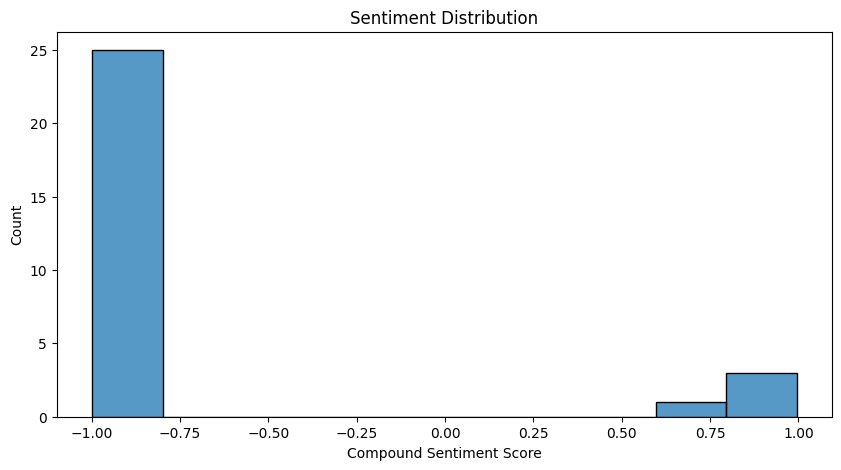

In [7]:
# Fetch and process articles
# Fetch and process articles
chosen_date = input("Enter date (YYYY-MM-DD, default 2025-04-23): ") or "2025-04-23"
articles = get_news_for_date(chosen_date)

if not articles:
    print("No articles found.")
else:
    print(f"Found {len(articles)} articles for {chosen_date}")
    
    # Track scraping success
    scraped_success = 0
    total_articles = len(articles)
    
   
    processed_articles = []
    for i in range(0, total_articles, 5):
        batch = articles[i:i + 5]
        print(f"Processing articles {i+1} to {min(i+5, total_articles)} of {total_articles}...")
        for article in batch:
            print(f"Article {i + batch.index(article) + 1}: {article.get('title', 'No Title')} - URL: {article.get('url', 'No URL')}")
        batch_processed = [preprocess_article(article) for article in batch]
        for article, processed in zip(batch, batch_processed):
            title_content_len = len((article.get('title', '') or '').strip() + ' ' + (article.get('content', '') or '').strip())
            if len(processed['original_text'].strip()) > title_content_len:
                scraped_success += 1
        processed_articles.extend(batch_processed)

    success_rate = (scraped_success / total_articles) * 100
    print(f"Scraping Success Rate: {success_rate:.2f}% ({scraped_success}/{total_articles} articles successfully scraped)")

    top_keywords = extract_keywords_yake(processed_articles, top_k=5)
    # topic_labels, topic_info = extract_topics(processed_articles, num_topics=5)
    print(f"Processed articles type: {type(processed_articles)}")
    print(f"Sample article: {processed_articles[0] if processed_articles else 'Empty'}")
    topic_labels, topic_info = extract_topics(processed_articles, num_topics=5, text_key='original_text')
    data = []
    for i, (article, keywords, topic) in enumerate(zip(processed_articles, top_keywords, topic_labels)):
        scraped_content = article['original_text']
        data.append({
            'Article': i + 1,
            'Title': article['title'] or 'No Title',
            'Description': article['description'] or 'No Description',
            'Summary': article['summary'] or 'No Summary',
            'Sentiment': f"Compound: {article['sentiment']['compound']:.4f} (Pos: {article['sentiment']['pos']:.2f}, Neg: {article['sentiment']['neg']:.2f})",
            'Entities': ', '.join([f"{ent[0]} ({ent[1]})" for ent in article['entities']]) or 'None',
            'Relations': ', '.join([f"{s} {v} {o}" for s, v, o in article['relations']]) or 'None',
            'Keywords': ', '.join([f"{word} ({score:.4f})" for word, score in keywords]) if keywords else 'None',
            'Topic': topic if topic is not None else 'None',
            'URL': articles[i].get('url', 'No URL'),
            'Scraped_Content': scraped_content
        })

    df = pd.DataFrame(data)
    display(df)

    print("\nTopic Information:")
    display(topic_info)

    if not topic_info.empty:
     topic_words = topic_info.iloc[0]['Words']
     if '(' in topic_words:  # Check for weighted terms
        try:
            word_scores = {word.split(' (')[0]: float(word.split('(')[1].strip(')')) 
                           for word in topic_words.split(', ')}
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title("Word Cloud for Topic 0")
            plt.savefig('topic_wordcloud.png')
        except Exception as e:
            print(f"Failed to generate word cloud: {e}")
    else:
        print("Skipping word cloud: No weighted terms for Topic 0")

    sentiment_scores = [article['sentiment']['compound'] for article in processed_articles]
    plt.figure(figsize=(10, 5))
    sns.histplot(sentiment_scores, bins=10)
    plt.xlabel("Compound Sentiment Score")
    plt.ylabel("Count")
    plt.title("Sentiment Distribution")
    plt.savefig('sentiment_distribution.png')  # Save instead of show

    csv_filename = f"news_analysis_{chosen_date}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"Results exported to {csv_filename}. Please upload this file for further analysis.")
    